# Analyze field constraints

In [2]:
import os
import sys
sys.path.insert(0, os.path.abspath(os.path.join(os.getcwd(), '..', '..')))
import optomization as opt
import legume
import json 
import numpy as np 
import matplotlib.pyplot as plt 

In [3]:
ks = np.linspace(np.pi*.5,np.pi,200)
gmax = 4.001
gmeParams = {'verbose':True,'numeig':30,'compute_im':False,'gmode_inds':[0,2,4],'kpoints':np.vstack([ks,[0]*len(ks)])}

phc = opt.W1(NyChange=0,Ny=7)
gme = legume.GuidedModeExp(phc,gmax=gmax)
gme.run(**gmeParams)

Running gme k-points: │------------------------------│ 1 of 200

KeyboardInterrupt: 

In [43]:
with open('/Users/dominic/Desktop/optGME/paper2/FullRun/media/ng30/ndbp1/loss_tests0/test7/meta_data.json', 'r') as f:
    opt_data2 = json.load(f)

phcOpt2 = opt.W1(vars=np.array(opt_data2['vars']),Ny=7)
gmeOpt2 = legume.GuidedModeExp(phcOpt2,gmax=gmax)
gmeOpt2.run(**gmeParams)

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Steps in GuidedModeExp: 589 plane waves and 3 guided modes ┃ Time (s) ┃                 % vs total T ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Guided modes computation with gmode_compute='exact'        │ 37.506   │ │--------------------│    3% │
│ Inverse matrix of Fourier-space permittivity               │ 0.057    │ │--------------------│    0% │
│ Matrix diagionalization using the 'eigh' solver            │ 1231.540 │ │█████████████████---│   89% │
│ Creating GME matrix                                        │ 120.090  │ │█-------------------│    9% │
├────────────────────────────────────────────────────────────┼──────────┼──────────────────────────────┤
│ Total time for real part of frequencies for 200 k-points   │ 1389.996 │ │████████████████████│  100% │
└────────────────────────────────────────────────────────────┴──────────┴──────────────────────────────┘

Skipping imaginary part computation, use run_im() to run it, or compute_rad() to compute the radiative rates of 
selected eigenmodes

In [44]:
ngsOpt2 = []
for i in range(200):
    ngsOpt2.append(opt.NG(gmeOpt2,i,14))
ngsOpt2 = np.array(ngsOpt2)

In [ ]:
ngs = []
for i in range(200):
    ngs.append(opt.NG(gme,i,14))
ngs = np.array(ngs)

In [4]:
import pickle

with open('testingGME.pkl', 'rb') as f:
    load_dict = pickle.load(f)

gme = load_dict['gme']
phc = load_dict['phc']
gmeParams = load_dict['gmeParams']
ks = load_dict['ks']
gmax = load_dict['gmax']
ngs = load_dict['ngs']

0.1638208048665195
0.17835263948781324
0.17835263948781324


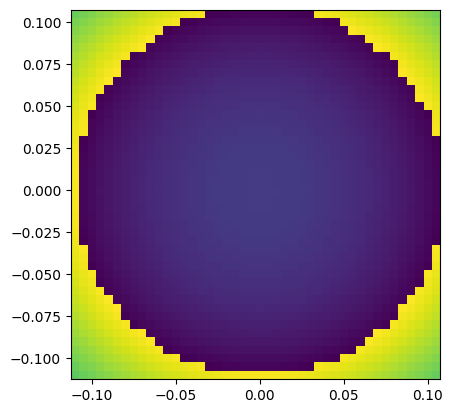

In [29]:
a=455
minabove = np.sqrt(3)/2
maxbelow = -np.sqrt(3)/2
dl = 0.005
x_grid = np.arange(-50/a,50/a,dl)
y_grid = np.arange(-50/a,50/a,dl)
X,Y = np.meshgrid(x_grid,y_grid)
field,_,_ = gme.get_field_xy('E',100,14,gme.phc.layers[0].d/2,xgrid=x_grid,ygrid=y_grid)


mask = np.ones_like(X)
for c in phc.layers[0].shapes:
    mask[np.sqrt((X-0)**2+(Y-0)**2)>50/a] = 1.5

cfields = mask*(np.abs(field['y']*np.conj(field['y'])+field['x']*np.conj(field['x'])))
cfieldsN = (np.abs(field['y']*np.conj(field['y'])+field['x']*np.conj(field['x'])))

print(np.min(cfieldsN))
print(np.min(cfieldsN[np.sqrt((X-0)**2+(Y-0)**2)<50/a]))
print(np.min(cfields))
plt.pcolormesh(X, Y, cfields)
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

In [45]:
fieldIn = []
a=455
for i in range(200):     
    minabove = np.sqrt(3)/2
    maxbelow = -np.sqrt(3)/2
    x_grid = np.linspace(-50/a,50/a,100)
    y_grid = np.linspace(maxbelow,minabove,100)
    X,Y = np.meshgrid(x_grid,y_grid)
    field,_,_ = gmeOpt2.get_field_xy('E',i,14,gme.phc.layers[0].d/2,xgrid=x_grid,ygrid=y_grid)
    cfields = (np.abs(field['y']*np.conj(field['y'])+field['x']*np.conj(field['x'])))
    minfield = np.min(cfields[np.sqrt((X-0)**2+(Y-0)**2)<50/a])
    purcell = minfield*3*np.pi*(299792458)**2*a*1E-9/(gmeOpt2.freqs[i,14]*2*np.pi*299792458/(a*1E-9))**2/np.sqrt(12)/(a*1E-9)**3

    fieldIn.append(purcell)


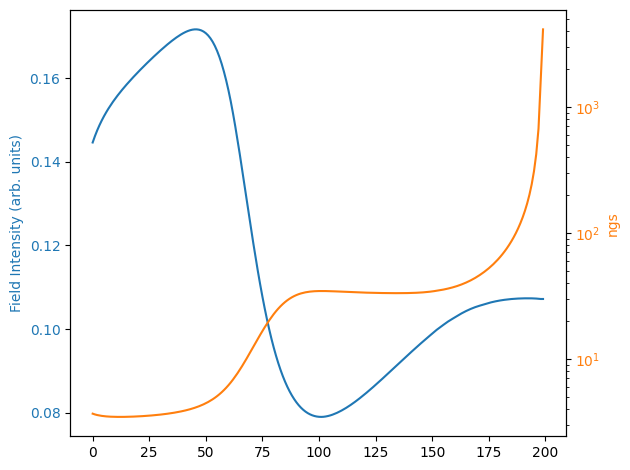

In [48]:
fig, ax1 = plt.subplots()
line1, = ax1.plot(np.array(fieldIn), color='tab:blue', label='Field Intensity')
ax1.set_ylabel('Field Intensity (arb. units)', color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')

ax2 = ax1.twinx()
ax2.plot(np.abs(ngsOpt2), color='tab:orange', label='ngs')
ax2.set_ylabel('ngs', color='tab:orange')
ax2.tick_params(axis='y', labelcolor='tab:orange')
ax2.set_yscale('log')

fig.tight_layout()
plt.show()

-33.359143396871325


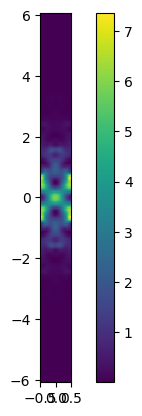

In [10]:
def PF(gme,phc,ngs,k,a):
    eps = np.real(legume.viz.eps_xy(phc,Nx=100,Ny=300,plot=False))
    f,_,_ = gme.get_field_xy('E',k,14,phc.layers[0].d/2,Nx=100,Ny=300,component='xyz')
    eabs = np.abs(np.conj(f['x'])*f['x'] + np.conj(f['y'])*f['y'] + np.conj(f['z'])*f['z'])

    #purcell enhancement calculation
    purcell = eabs*3*np.pi*(299792458)**2*a*1E-9*np.abs(ngs[k])/(gme.freqs[k,14]*2*np.pi*299792458/(a*1E-9))**2/np.sqrt(12)/(a*1E-9)**3
    return purcell

p = PF(gme,phc,ngs,125,455)

print(ngs[125])
plt.pcolormesh(X, Y, p)
plt.colorbar()
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

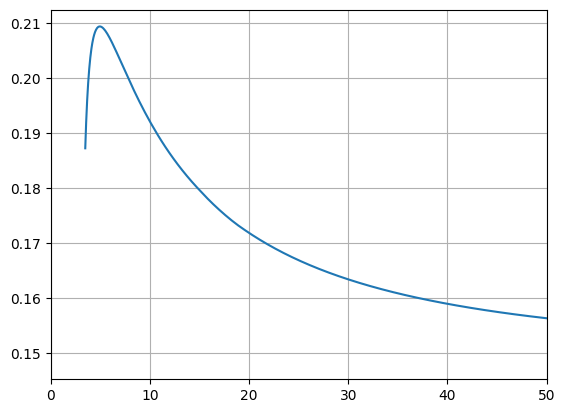

In [42]:
plt.plot(np.abs(ngs),fieldIn)
plt.xlim(0,50)
plt.grid(True)

In [49]:
backscatterParams = {'a':455,'sig':3,'lp':40,'phidiv':45,'zdiv':10}

lossOG = []
lossOpt2 = []
for i in range(200):
    lossOG.append(10**opt.backscatterLog(gme,phc,14,k=i,**backscatterParams)/backscatterParams['a']/1E-7*10*np.log10(np.e))
    lossOpt2.append(10**opt.backscatterLog(gmeOpt2,phcOpt2,14,k=i,**backscatterParams)/backscatterParams['a']/1E-7*10*np.log10(np.e))



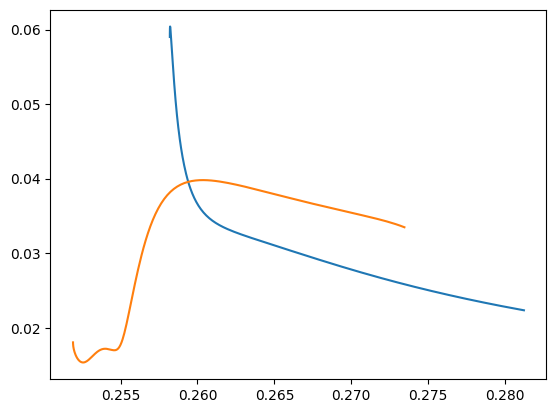

In [50]:
plt.plot(gme.freqs[:,14],lossOG)
plt.plot(gmeOpt2.freqs[:,14],lossOpt2)
plt.show()